# Perceptrons and the XOR problem
#### Arvind Suresh, 02/25/2025

## Introduction

### Parametric models
Neural networks are a class of mathematical functions (also called a **model** in ML parlance). They are **parametric** models, which means that they are defined by a collection of parameters (i.e. constants that show up in a formula). Before attempting to state what these formulas look like, it is useful to consider two examples of parametric functions that we are already familiar with, and which are in some sense natural pre-cursors of NNs (or, depending on how you define NNs, even special cases).
1. **Linear models**: This is arguably the most common model used for regression problems because of the simplicity and interpretability. These are functions of the form 
\begin{align*}
    F_{W,\mathbf{b}} : \mathbb{R}^n & \to \mathbb{R}^m\\
    \mathbf{x} & \mapsto W\mathbf{x} + \mathbf{b},
\end{align*}
where $W \in \mathbb{R}^{m \times n}$ is a matrix and $\mathbf{b} \in \mathbb{R}^m$ is a vector. The parameters of this function are the entries of the matrix $W$ (called **weights**) and the vector $\mathbf{b}$ (called the **bias**). 

There are two useful ways to understand the formula for linear models:

- *Row-wise*: The rows of $W$ should be thought of as input vectors living in $\mathbb{R}^n$.  If $\mathbf{w}_i^T \in \mathbb{R}^n$ is the $i$-th row of $W$, then the $i$-th entry of the output is given by
\begin{align*}
    F_{W,\mathbf{b}}(\mathbf{x})_i = \mathbf{w}_i^T \mathbf{x} + b_i.
\end{align*}
- *Column-wise*: The columns of $W$ should be thought of as output vectors living in $\mathbb{R}^m$. In fact, the $j$-th column $\mathbf{c}_j \in \mathbb{R}^m$ is the nothing but $W\mathbf{e}_j$ (the coordinate vector), and the output vector is simply a linear combination
\begin{equation*}
    F_{W,\mathbf{b}}(\mathbf{x}) = \sum_{j=1}^m \mathbf{c}_j x_j + \mathbf{b}.
\end{equation*}
NOTE: It is not perhaps more accurate (safe?) to call these **affine functions**, so as not to confuse them with *linear transformations* from linear algebra (which are functions of the form $F(\mathbf{x}) = W\mathbf{x}$), but in ML parlance it is common to refer to these as linear functions.
2. **Logistic regression models**: These are arguable the most model for binary classification. They are functions of the form
\begin{align*}
    G_{W,\mathbf{b}} : \mathbb{R}^n & \to \mathbb{R}\\
    \mathbf{x} & \mapsto \sigma(\mathbf{w}^T\mathbf{x} + b),
\end{align*}
where $\sigma : \mathbb{R} \to \mathbb{R}$ is the **sigmoid function** defined by
\begin{align*}
    \sigma(z) = \frac{1}{1 + e^{-z}}.
\end{align*}
NOTE: The logistic regression model is simply a composition of a linear model (to $\R$) with a sigmoid:
\begin{equation*}
    \mathbb{R}^n \xrightarrow{\textup{linear}} \mathbb{R} \xrightarrow{\textup{sigmoid}} \mathbb{R}.
\end{equation*}
3. **Multi-class logistic regression models**: These are used for multi-class classification. They are functions of the form
\begin{align*}
    H_{W,\mathbf{b}} : \mathbb{R}^n & \to \mathbb{R}^m\\
    \mathbf{x} & \mapsto S(W\mathbf{x} + \mathbf{b}),
\end{align*}
where $S : \mathbb{R}^m \to \mathbb{R}^m$ is the **softmax function** defined by
\begin{align*}
    S(\mathbf{z}) = \left( \frac{e^{z_1}}{\sum_{j=1}^m e^{z_j}}, \ldots, \frac{e^{z_m}}{\sum_{j=1}^m e^{z_j}} \right) \in \mathbb{R}^m.
\end{align*}
The output is regarded as a probability distribution over the $m$ classes (each class corresponds to an axis of the output vector).
The multi-class logistic regression model is simply a composition of a linear model with a softmax:
\begin{equation*}
    \mathbb{R}^n \xrightarrow{\textup{linear}} \mathbb{R}^m \xrightarrow{\textup{softmax}} \mathbb{R}^m.
\end{equation*}
NOTE: If we set $m=2$, then some algebraic manipulation reveals that the multi-class logistic regression model is equivalent to the logistic regression model (Exercise: verify this).


### What is a neural network?
Neural networks are a generalization of the above models, which mix linear functions with non-linear functions in a sequential manner:
\begin{align*}
    \mathbb{R}^n & \xrightarrow{\textup{linear}} \mathbb{R}^{h_1} \xrightarrow{\textup{non-linear}} \mathbb{R}^{h_1} \xrightarrow{\textup{linear}} \mathbb{R}^{h_2} \xrightarrow{\textup{non-linear}} \mathbb{R}^{h_2} \to \dotsb \to \mathbb{R}^m.
\end{align*}
Some terminology:
- The first $\mathbb{R}^n$ is the **input layer**.
- The last $\mathbb{R}^m$ is the **output layer**.
- The intermediate $\mathbb{R}^{h_i}$ are the **hidden layers**.
- The number of layers is called the **depth** of the network.
- The number of hidden units in the $i$-th layer is called the **width** of the $i$-th layer.
- The non-linear functions in between the linear functions are called **activation functions** (typically, the same activation function is used for all layers).
- The parameters of the network are the weights and biases of the linear functions, as well as the parameters of the activation functions (if any). Collectively, they are all referred to as the weights of the network.

### Why neural networks?
There are several reasons why neural networks are useful and popular. Let me state two of them:
1. **Universal function approximators**: Neural networks are universal function approximators, which means that they can approximate any continuous function to arbitrary precision. We like this because it means that when we sit down to model our data, there is a (suitably complex) neural network that will do what we want, and we don't run the risk of investing time and energy on a model that is fundamentally incapable of doing what we want.
2. **Scalability**: Neural networks are highly scalable to large datasets. This is because the bulk of the computations inside a neural network are dot products (multiply-and-add), which are highly parallelizable and can be efficiently implemented on modern hardware (GPUs, TPUs, etc.). 

I am not particularly equipped to say much (anything?) about point 2, but I will try to say a little bit about point 1 below.

### Universal approximation
Recall that in (supervised) ML we have the following setup:
- We have a collection of variables $\mathbf{x} \in \mathbb{R}^n$ (called **features**, or regressors, or predictors, etc.) that arise from measurements of some quantity in the real world.
- We have a collection of variables $\mathbf{y} \in \mathbb{R}^m$ (called **labels**, or responses, or outcomes, etc.) that arise from measurements of some other quantity in the real world.
- We have reason to believe that there is a forward relationship between the features and the labels, which (loosely speaking) is captured in the form of a **ground truth** function $\mathbf{F}: \mathbb{R}^n \to \mathbb{R}^m$.
- We have a collection of **labelled dataset** $\mathcal{D} = \{(\mathbf{x}_i, \mathbf{y}_i)\}_{i=1}^N$ which (according to our belief) is a sample from the ground truth function $\mathbf{F}$.
- We want to construct/define/build a function $F$ that approximates the ground truth function $\mathbf{F}$ by *learning* from the data $\mathcal{D}$.
- We want to use the function $F$ to make predictions on new data (i.e. data that is not in the dataset $\mathcal{D}$).

Before understanding the practical aspect of what it means to learn from data, it is useful to get an understanding of the theoretical or mathematical aspect: *What does it mean to approximate a function?* I find a geometric perspective very useful:
- The ground truth function $\mathbf{F}$ is simple one element/point in a gigantic space of functions (for example, all continuous functions from $\mathbb{R}^n$ to $\mathbb{R}^m$).
- The function $F$ that we wish to construct is another element of this space of functions, which is in some sense close to the ground truth function $\mathbf{F}$.
- To make sense of "close", we need a notion of distance between functions, also called a **norm** or **metric**. There are many ways to define a distance between functions:
    - $L_{\infty}$-norm: The distance of $F$ from $\mathbf{F}$ is the largest individual distance on any input.
    - $L_1$-norm: The distance of $F$ from $\mathbf{F}$ is the average distance on all inputs.
    - $L_2$-norm: The distance of $F$ from $\mathbf{F}$ is the average squared distance on all inputs.

Now, in order to search for a function $F$ that can potentially approximate $\mathbf{F}$, we restrict our candidates for $F$ to a subset of the space of functions- these are models! The goal then is to find a subset (i.e. model) that is "dense" in the function space, which means that for any function $\mathbf{F}$, there is a function $F$ in the model that is arbitrrily close to $\mathbf{F}$. This is what it means for a model to be a **universal function approximator**.

**Example**: The linear model is not a universal function approximator. This is because the linear model can only approximate functions that are linear (or affine). For example, the function $F(x) = x^2$ cannot be approximated by a linear model (no matter the choice of metric).

**Example**: The logistic regression model is not a universal function approximator. This is because the logistic regression model can only approximate functions that are monotone (increasing or decreasing). For example, the function $F(x) = x^2$ cannot be approximated by a logistic regression model (no matter the choice of metric).

**Example**: Polynomial functions are (more or less) universal function approximators with the $L_{\infty}$ norm; this is made precise in the famous *Stone-Weierstrass theorem*. 

**Example**: With respect to the $L_{\infty}$ norm, the set of neural networks of the form
\begin{align*}
    N: \mathbb{R}^n & \xrightarrow{\textup{linear}} \mathbb{R}^{h_1} \xrightarrow{\textup{sigmoid}} \mathbb{R}^{h_1} \xrightarrow{\textup{linear}} \mathbb{R}^{h_2} \xrightarrow{\textup{sigmoid}} \mathbb{R}^{h_2} \to \dotsb \to \mathbb{R}^m
\end{align*}
is dense in a suitable space of functions. For precise versions of this statement, I refer you to the wikipedia page on the UAT: https://en.wikipedia.org/wiki/Universal_approximation_theorem

**Remark.** The UAT is a theoretical result, and it does not say anything about the practical ability of a neural network to approximate a function. In particular, it does not say anything about the ability of a neural network to learn from data. It is simply a statement that there exists a neural network that can approximate any function (in some sense), so it is telling us that, at the very least, we are not theoretically limited by the choice of a neural network model. 

**Remark.** Note that in order to train a model to "learn from data", what we need is way to measure the distance between the model and the ground truth function *on the given data*. This is nothing but the **loss function**. So, you can think of the loss function as an approximate measure of the distance between $F$ and $\mathbf{F}$ in the abstract function space. As we train the model, we are tuning the paramaters in such a way that our $F$ gets closer to $\mathbf{F}$ on the data.

### Neural network architectures
The particular configuration of linear and non-linear functions that make up a neural network is called the **architecture** of the neural network. There are many different architectures, and they are typically chosen based on the type of data that we are working with. 

The basic building blocks of neural networks are called **perceptrons**. When we stack perceptrons together in layers, we get a **multilayer perceptron** (MLP), also called a **feedforward neural network** (so named because data flows in only one direction, from input to output). 

MLPs are the most basic type of neural network, and when we add some special sauce to them, we get more advanced architectures (for example, convolutional neural networks). On the other hand, there are also more basic architectures that are not MLPs, such as recurrent neural networks (RNNs). 

In the next class, we will discuss CNN's and their implementation in PyTorch. In this class, we focus on perceptrons, and in particular, some of the historical context around them. 

## Perceptrons

### Biological inspiration
Consider how the brain works:
- The brain is made up of billions of cells called **neurons**.
- Neurons are connected to each other through **synapses**.
- Each neuron receives signals from other neurons through these synapses.
- Each connection has a different strength (or “weight”), which determines how much influence one neuron (the input) has over another (the output).
- When a neuron receives enough input from other neurons, it “fires” or "activates" and sends a signal to other neurons.
- The "enough input" is determined by a threshold specific to the neuron, which is a fixed value that the input must exceed in order for the neuron to fire.

### McCulloch-Pitts model
The starting point for creating a mathematical abstraction of this process is to view the neurons task as one of *binary classification*: the neuron receives a collection of inputs, and it has to decide whether to fire or not.

Warren McCulloch and Walter Pitts were the first to propose a mathematical model of a neuron in 1943 (as such, they are credited with being the inventors of the concept of an artificial neural network). They were both trained in mathematics and logic, and they were interested in the question of how the brain could perform logical operations. They proposed a model of a neuron that was based on the idea of a binary threshold unit, which is a simple mathematical function that takes a collection of inputs and produces a binary output (either 0 or 1). Each neuron was in a state of $0$ (inactive) or $1$ (active), and the neuron would change its state based on the inputs it received. 

In their model, the neurons were arranged into layers, with each layer corresponding to a time-step in the processing of information. Thus, a neuron at time $t$ would receive inputs from neurons at time $t-1$, and it would produce an output that would be sent to neurons at time $t+1$, and so on. This modelled the flow of information as a directed graph, and they proved (in some precise sense) that if the graph was acyclic, then the network of neurons could perform any logical operation. I refer you to the wikipedia article and associated links for more information: https://en.wikipedia.org/wiki/Neural_network#McCulloch%E2%80%93Pitts_neuron

### Rosenblatt's perceptron
In 1958, at the Cornell Aeronautical Laboratory, Frank Rosenblatt implemented (or simulated) a working model of the McCulloch-Pitts neuron, which he called the **perceptron**. He was a psychologist and computer scientist, and he was interested in the question of how the brain could learn from experience. He proposed a model of a perceptron that was based on the idea of a learning algorithm, which is a set of rules that can be used to update the weights of the connections between neurons in order to improve the performance of the network. This process is now recognized as a simplified/discretized form of **gradient descent**. 

Check out the wikipedia article for more information, and some pictures of a room-sized perceptron: https://en.wikipedia.org/wiki/Perceptron

### Formal definition of a perceptron
In the language of modern ML, a perceptron is a **binary classifier** that is built as follows:
- Each neuron receives a collection of inputs $\mathbf{x} = (x_1, \ldots, x_n) \in \mathbb{R}^n$ (the signals).
- Each input has a weight $w_i \in \mathbb{R}$ (the strength of the connection).
- The neuron computes a weighted sum of the inputs: $z = \sum_{i=1}^n w_i x_i$.
- The neuron has it's own threshold $t \in \mathbb{R}$ (the neuron-specific threshold).
- The neuron fires if $z \geq t$, and does not fire otherwise.
- Thus, the output of a neuron can be expressed as binary output: $y = 1$ if $z \geq t$, and $y = 0$ otherwise.

To connect back to the models we wrote down earlier, observe that if we set $b = -t$, then the above process can be summarized as a function $P_{\mathbf{w},b}: \mathbb{R}^n \to \{0,1\}$ that is a composition:
\begin{equation*}
    \mathbb{R}^n \xrightarrow{F_{\mathbf{w},b}} \mathbb{R} \xrightarrow{H} \{0,1\},
\end{equation*}
in which the first function $F_{\mathbf{w},b}$ is linear, and the second function $H$ is the **Heaviside step function** defined by
\begin{align*}
    H(z) = \begin{cases}
        1 & \textup{if } z \geq 0,\\
        0 & \textup{if } z < 0.
    \end{cases}
\end{align*}
Thus, the function $P_{\mathbf{w},b}$ can be written directly as
\begin{equation*}
    P_{\mathbf{w},b}(\mathbf{x}) = H(F_{\mathbf{w},b}(\mathbf{x})) = \begin{cases}
        1 & \textup{if } \mathbf{w}^T\mathbf{x} + b \geq 0,\\
        0 & \textup{if } \mathbf{w}^T\mathbf{x} + b < 0.
    \end{cases}
\end{equation*}

### Linearity of the perceptron
The perceptron is a linear classifier, which means that it partitions the input space $\mathbb{R}^n$ into two half-spaces by a hyperplane, and predicts $1$ on one side of the hyperplane and $0$ on the other side. 
This can be understood for a fixed $\mathbf{w} \in \mathbb{R}^n$ and $b = 0$ as follows:
- Start by visualizing the set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} = 0$. This is the **orthogonal subspace** to $\mathbf{w}$. This depends only on the direction of $\mathbf{w}$ and not its magnitude.
- The set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} > 0$ is a half-space (the positive half). This is the set of $\mathbf{x}$ that are "on the same side" of the hyperplane as $\mathbf{w}$.
- The set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} < 0$ is a half-space (the negative half). This is the set of $\mathbf{x}$ that are "on the opposite side" of the hyperplane as $\mathbf{w}$.

If the bias term $b$ is non-zero, then this corresponds to shifting the previous picture along the line $\textup{span}(\mathbf{w})$ by $-b$! 

### The Perceptron Learning Algorithm

The Perceptron Learning Algorithm is a fundamental method for training a simple binary classifier. It is an iterative method that updates the weights of a perceptron based on errors made in classification. Below is a detailed breakdown of how it works.

#### Setup and Notation

We have:
- **Input features**: $\mathbf{x}$, where each sample $\mathbf{x}_i$ has $n$ features.
- **Binary labels**: $y$ ($0$ or $1$).
- **Weights**: $\mathbf{w}$, initialized to zeros or small random values.
- **Bias**: $b$, initialized to zero.
A perceptron makes predictions using a linear decision rule:
$$\hat{y} = H(\mathbf{w} \cdot \mathbf{x} + b),$$
where:
- $\mathbf{w} \cdot \mathbf{x}$ is the dot product of the weight vector and input features.
- $b$ is the bias term (optional but useful).
- $H$ is $1$ if the input is postive, $0$ otherwise$.

#### Learning Algorithm

**Step 1: Initialize Weights and Bias**: Set all weights $\mathbf{w}$ to zero, and also $b=0$.

**Step 2: Iterate Over the Dataset**

For each training sample $(\mathbf{x}_i, y_i)$:
- *Make prediction*: $\hat{y}_i = \text{sign}(\mathbf{w} \cdot \mathbf{x}_i + b).$
- *Update rule*: Update the weights and bias as follows:
\begin{align*}
    \mathbf{w} &\leftarrow \mathbf{w} + \eta (y_i - \hat{y}_i) \mathbf{x}_i,\\
    b &\leftarrow b + \eta (y_i - \hat{y}_i),
\end{align*}
where $\eta$ is the learning rate (a small positive constant, e.g., 0.01). Note: If $y_i = \hat{y}_i$, then the update does nothing! If $y_i \neq \hat{y}_i$, then the update moves the weights and bias in the direction that reduces the error.

**Step 3: Repeat Until Convergence**: Continue updating until all points are correctly classified or a maximum number of iterations is reached.

If the data is linearly separable (i.e. there actually does exist a hyperplane which divides the two classes), then the algorithm is guaranteed to converge to a solution!

Weights: [-0.10741437 -0.5077867 ]
Bias: -0.4
Final Accuracy: 0.91


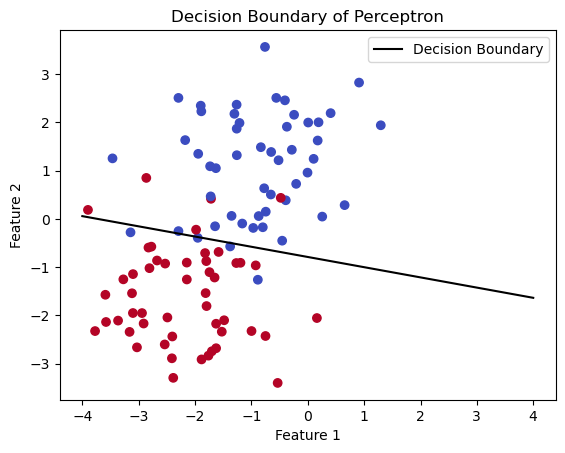

In [11]:
# import libraries for data generation and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_blobs

# Create two horizontally separated blobs
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.0, 
                  center_box=(-3.0, 3.0))
# Move the blobs horizontally apart by adding offset to x coordinates
X[y == 0, 0] -= 1  # Move left blob further left
X[y == 1, 0] += 1  # Move right blob further right

# import precpetron class
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron(max_iter=1000, # Maximum number of iterations
                        eta0=0.1, # Learning rate
                        tol=1e-3, # Tolerance for stopping criteria, i.e. if the change in loss is less than this value, training stops
                        random_state=42, # Random seed for reproducibility
                        early_stopping=True, # Stop once the validation score is not improving
                        validation_fraction=0.1 # Fraction of training data to set aside as validation set for early stopping
                        )
# Fit the model to the dataset
perceptron.fit(X, y)
# Get the weights and bias from the trained model
weights = perceptron.coef_[0]
bias = perceptron.intercept_[0]
# Calculate the slope and intercept of the decision boundary
slope = -weights[0] / weights[1]
intercept = -bias / weights[1]

# Print the weights and bias
print("Weights:", weights)
print("Bias:", bias)
# Print the final accuracy of the model
print("Final Accuracy:", perceptron.score(X, y))

#visualize the decision boundary
fig, ax = plt.subplots()
# make axis background white
ax.set_facecolor('white')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
x_vals = np.linspace(-4, 4, 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='black', label='Decision Boundary')
plt.title("Decision Boundary of Perceptron")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


# # Visualize the dataset
# fig, ax = plt.subplots()
# ax.set_facecolor('white')
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
# plt.title("Linearly Separable Dataset")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.show()

Given below is a manual implementation which has a bug somewhere. 

**Exercise**: Find the bug and fix it!

In [ ]:
class Perceptron:
    """
    A simple Perceptron model that tracks the evolution of the decision boundary
    as well as the training accuracy at the end of each epoch.
    """
    def __init__(self, learning_rate=0.1, epochs=10):
        """
        Initialize the Perceptron.

        Parameters:
            learning_rate (float): The step size for weight updates.
            epochs (int): The number of passes through the entire training dataset.
        """
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.history = []         # Store decision boundary parameters (weights, bias) at each epoch
        self.accuracy_history = []  # Store training accuracy at each epoch

    def fit(self, X, y):
        """
        Train the Perceptron model on the dataset (X, y) and store the decision boundary
        and accuracy after each epoch.

        Parameters:
            X (array-like): Training data of shape (n_samples, n_features).
            y (array-like): Binary labels for training data with values 0 and 1.
        """
        n_samples, n_features = X.shape
        self.weights = np.ones(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            # Iterate over each sample in the dataset
            for i in range(n_samples):
                yhat = np.dot(X[i], self.weights) + self.bias
                # Update weights and bias if the prediction is incorrect
                self.weights += self.lr * (y[i] - yhat) * X[i]
                self.bias += self.lr * (y[i] - yhat)
            
            # Store decision boundary parameters after each epoch
            self.history.append((self.weights.copy(), self.bias))
            
            # Compute training accuracy for the current epoch
            predictions = self.predict(X)
            accuracy = np.mean(predictions == y)
            self.accuracy_history.append(accuracy)
            print(f"Epoch {epoch+1}/{self.epochs}: Accuracy = {accuracy * 100:.2f}%")

    def predict(self, X):
        """
        Make predictions for the input data X using the learned weights and bias.

        Parameters:
            X (array-like): Data for which to make predictions.

        Returns:
            array: Predicted labels with values -1 or 1.
        """
        return np.sign(np.dot(X, self.weights) + self.bias)

## From Perceptrons to MLPs

### XOR problem
The **XOR (exclusive OR) function** is a simple binary operation with the following truth table:

| \( x_1 \) | \( x_2 \) | \( y \) (XOR) |
|------|------|----|
| 0  | 0  | 0  |
| 0  | 1  | 1  |
| 1  | 0  | 1  |
| 1  | 1  | 0  |

The key challenge is that *XOR is not linearly separable*, meaning there is no single straight line that can correctly separate the two classes in a 2D plane. Since a perceptron can only learn linear decision boundaries, it fails to classify XOR correctly.

### Historical Significance
- In 1969, Marvin *Minsky and Seymour Papert* published *Perceptrons*, proving that a perceptron cannot learn the XOR function, or more generally, any non-linearly separable function. This led to a decline in neural network research, known as the **"AI Winter"**. Strangely enough, in the same paper, they also noted that a multi-layer perceptron (MLP) could solve XOR, but this was largely overlooked!
- In 1986, *Geoffrey Hinton, David Rumelhart, and Ronald Williams* revived interest in neural networks by introducing the backpropagation algorithm, allowing **multi-layer perceptrons (MLPs)** to solve XOR and other complex problems.

### Solution to the XOR Problem
The XOR function can be correctly classified by introducing a hidden layer in a neural network. An MLP with non-linear activation functions (such as sigmoid or ReLU) can learn a *non-linear decision boundary*, making it possible to solve XOR.

We present below a simple implementation of an MLP to solve the XOR problem, using `PyTorch`.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# XOR dataset
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32) # Input features
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32) # Target labels

# Define the MLP model
class XORMLP(nn.Module):
    def __init__(self):
        super(XORMLP, self).__init__()
        self.hidden = nn.Linear(2, 2)  # Two neurons in hidden layer
        self.output = nn.Linear(2, 1)  # One neuron in output layer
        self.activation = nn.Tanh()    # Non-linear activation for hidden layer
        self.final_activation = nn.Sigmoid()  # Sigmoid for binary classification

    # Forward pass through the network to make predictions
    def forward(self, x):
        x = self.activation(self.hidden(x)) # Apply activation function to hidden layer
        x = self.final_activation(self.output(x)) # Apply sigmoid to output layer
        return x

In [13]:
# Initialize model
model = XORMLP()

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss, nice because it is convex and differentiable!
optimizer = optim.SGD(model.parameters(), # Stochastic Gradient Descent optimizer
                      lr=0.1 # Learning rate
                      )

In [14]:
# Training loop
epochs = 10000 # Number of epochs to train the model. This is the number of times the model will see the entire dataset.
# Loop over the number of epochs
losses = {} # Dictionary to store losses for each epoch
for epoch in range(epochs):
    optimizer.zero_grad() # Zero the gradients before each epoch
    outputs = model(X) # Forward pass through the model to get predictions
    loss = criterion(outputs, y) # Compute the loss between predictions and true labels
    loss.backward() # Backpropagation to compute gradients
    optimizer.step() # Update model parameters using the optimizer
    
    # Store the loss for every 200 epochs
    if epoch % 200 == 0:
        losses[epoch] = loss.item() # Store the loss value in the dictionary

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 0.6927
Epoch 1000, Loss: 0.3953
Epoch 2000, Loss: 0.3592
Epoch 3000, Loss: 0.3535
Epoch 4000, Loss: 0.3513
Epoch 5000, Loss: 0.3501
Epoch 6000, Loss: 0.3494
Epoch 7000, Loss: 0.3489
Epoch 8000, Loss: 0.3486
Epoch 9000, Loss: 0.3483


In [15]:
# Test the model
with torch.no_grad():
    predictions = model(X)
    print("Predictions:", predictions.round().squeeze().tolist())

Predictions: [0.0, 0.0, 1.0, 1.0]


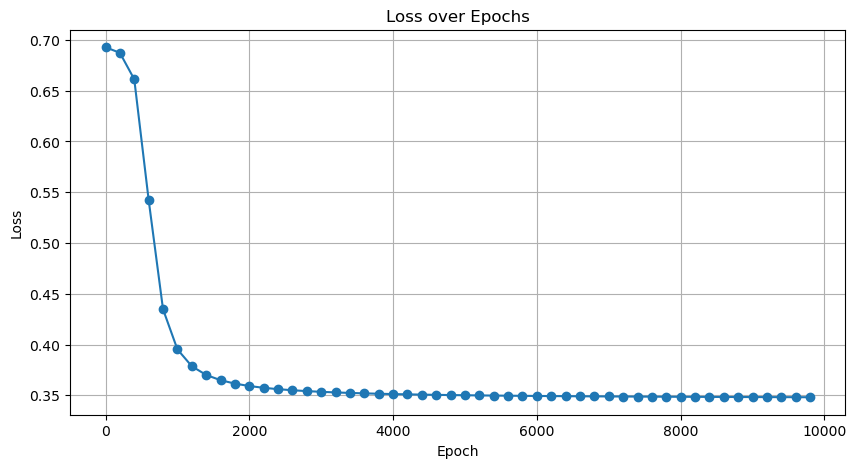

In [16]:
# Visualize the loss over epochs using the losses dictionary
plt.figure(figsize=(10, 5))
plt.plot(list(losses.keys()), list(losses.values()), marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Next time
We will discuss the implementation of CNNs in PyTorch, and how they can be used to solve image classification problems. 